In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

import kornia
from mish_cuda import MishCuda

from tqdm.notebook import tqdm

PATH = Path('../..').resolve()

%matplotlib inline

seed = 12345

In [2]:
torch.cuda.set_device('cuda:1')

# reproducability flags
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def root_mean_squared_error(preds, targs):  return torch.sqrt(F.mse_loss(preds.reshape(-1, 1), targs.reshape(-1, 1)))
def slope(p, y): return ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

item_tfms = []
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize.from_stats(*image_stats)]

In [48]:
# Grad-CAM 
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()



class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

# plot penultimate layer of our custom xresnet architecture
def plot_gradcam(x, learn, hooked_layer):
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(8.5, 3), dpi=150)

    x_img = TensorImage(dls.train.decode((x,))[0][0])
    
    
    for i, ax in zip([0, 1, 2], axes):

        if i == 0:
            x_img.show(ax=ax)
            ax.set_axis_off()
            continue

        with HookBwd(hooked_layer) as hookg:
            with Hook(hooked_layer) as hook:
                output = learn.model.eval()(x.unsqueeze(0).cuda())
                act = hook.stored
            output[0,i-1].backward()
            grad = hookg.stored
            p0, p1 = output.cpu().detach()[0]

            w = grad[0].mean(dim=(1,2), keepdim=True)
            cam_map = (w * act[0]).sum(0).detach().cpu()
            
            cam_map = np.where(cam_map >= 0, cam_map / cam_map.max(), 0)

            x_img.show(ax=ax)
            ax.imshow(
                cam_map, alpha=0.6, extent=(0,224,224,0),
                interpolation='bicubic', cmap='inferno'
            )
            ax.set_axis_off()
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.01)
    
    return (fig, axes, *(np.exp([p0, p1]) / np.exp([p0, p1]).sum()))
    


In [5]:
# pipeline for processing images at a time
type_tfms = [PILImage.create]
item_tfms = [Resize(224), ToTensor()]
type_pipe = Pipeline(type_tfms)
item_pipe = Pipeline(item_tfms)
norm = Normalize.from_stats(*image_stats)
i2f = IntToFloatTensor()

# plotting kwargs
text_dict = dict(
    ha='center',
    color='white',
    fontsize=18
)

# ALFALFA

## Formulate classification problem

In [6]:
a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})
a40 = a40[(a40.logfgas > 0.5) | (a40.logfgas < -0.5)]
a40['gas_rich'] = np.where(a40.logfgas > 0, True, False)

In [7]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['gas_rich'])]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a40, path=PATH, bs=64)

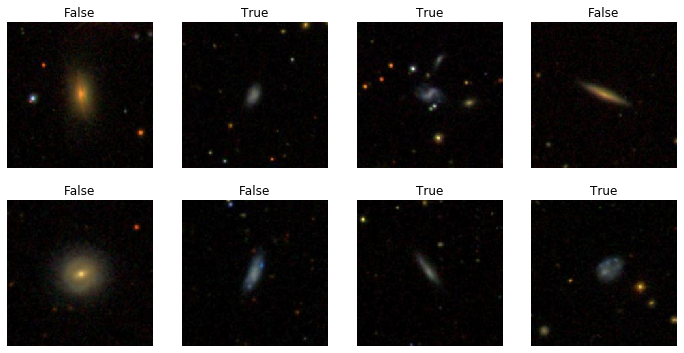

In [8]:
dls.show_batch(nrows=2, ncols=4)

## Get trained resnet-like model

In [134]:
model = XResNet(ResBlock, 1, [2, 2], stem_szs=[16, 32, 64])
model[-1] = nn.Linear(in_features=128, out_features=2)

learn = Learner(
    dls, 
    model,
    metrics=accuracy,
    opt_func=ranger,
)

In [135]:
learn.fit_one_cycle(10, 1e-2)

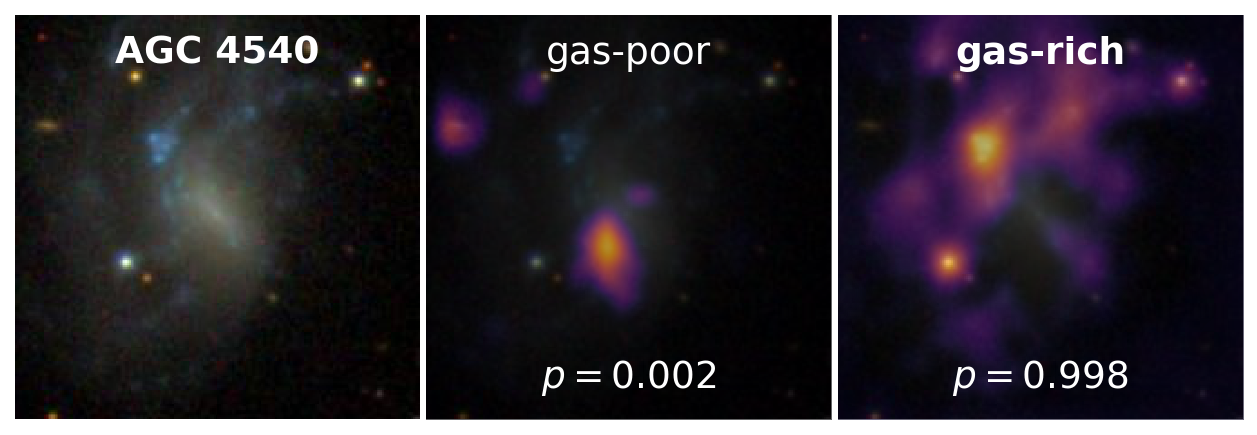

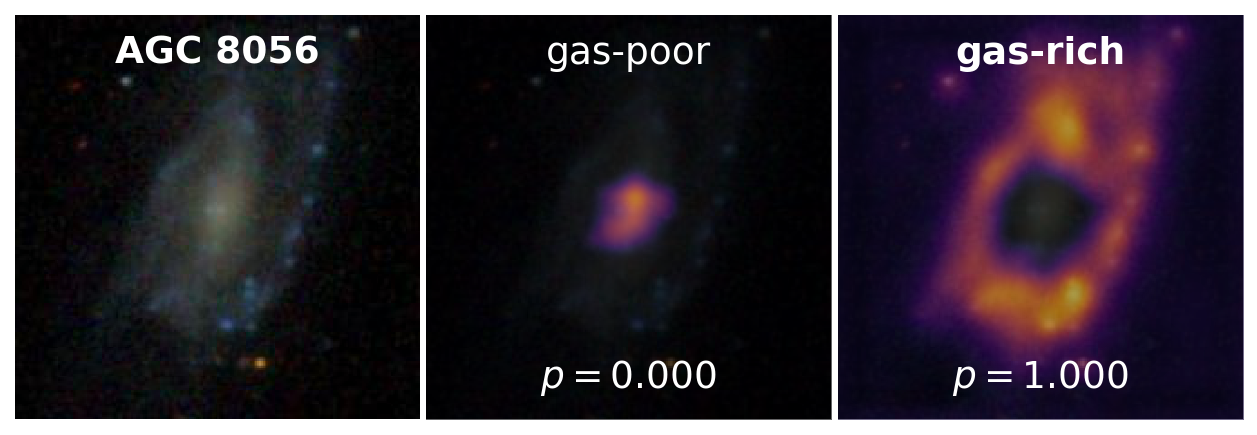

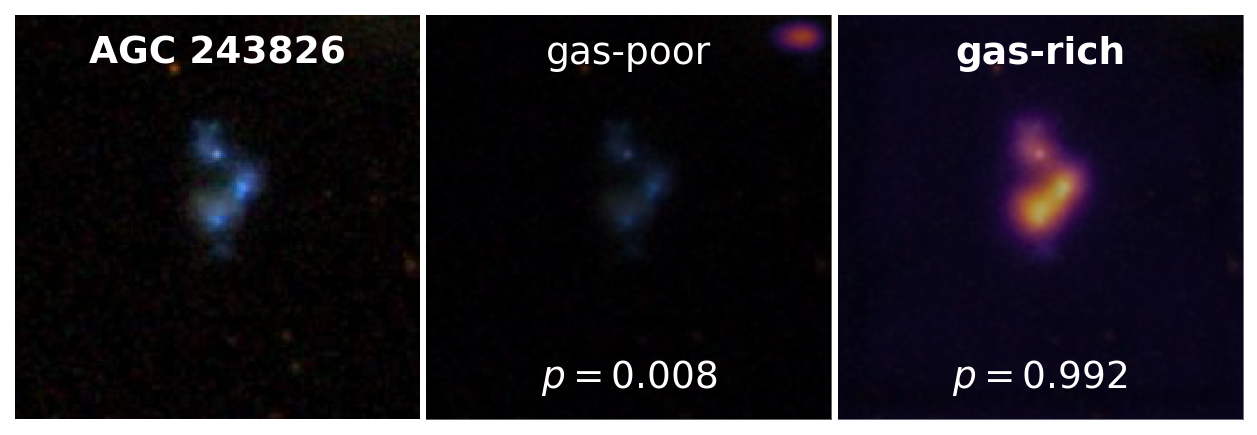

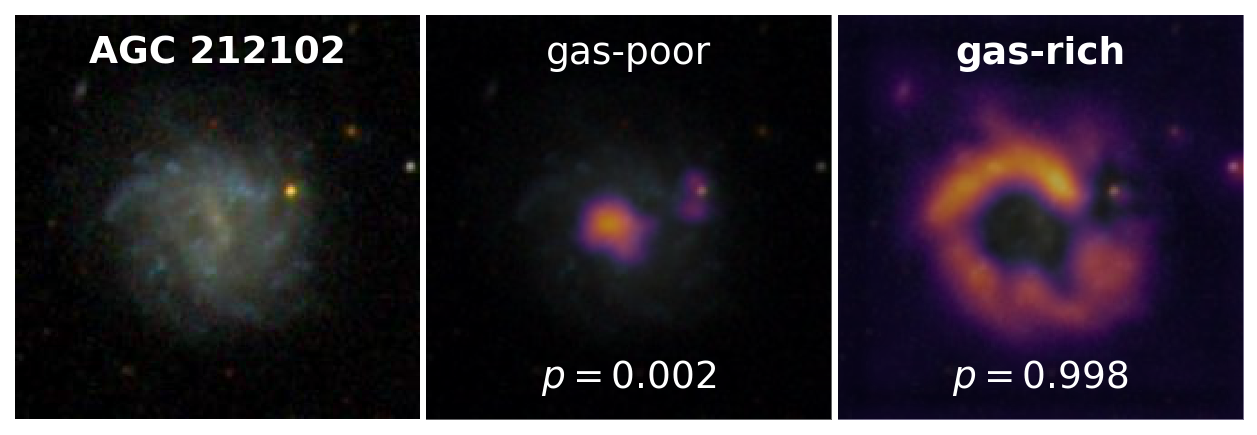

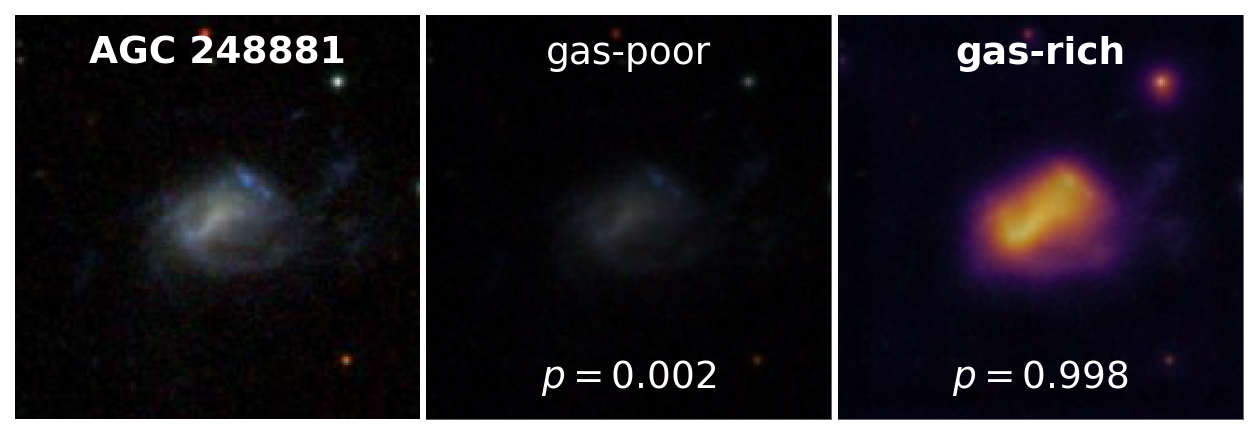

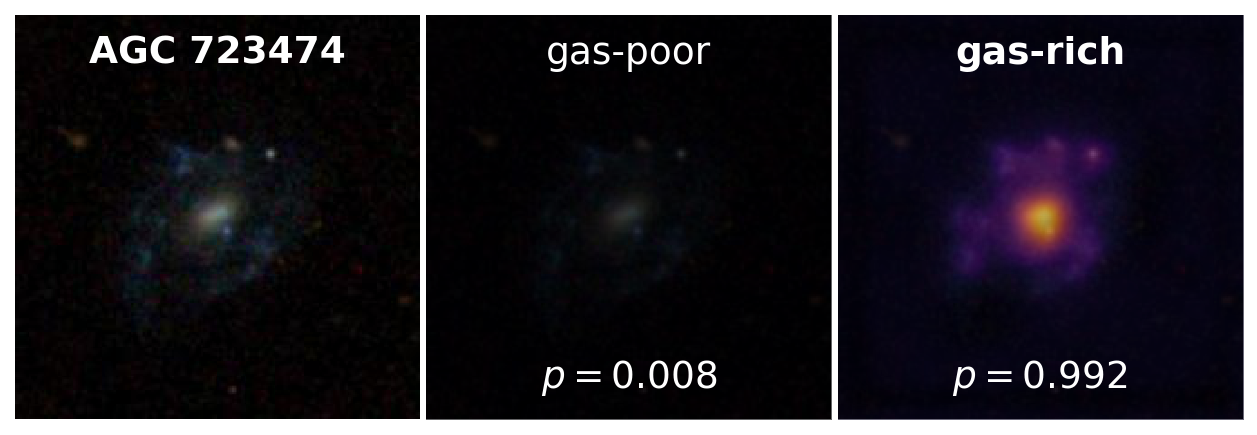

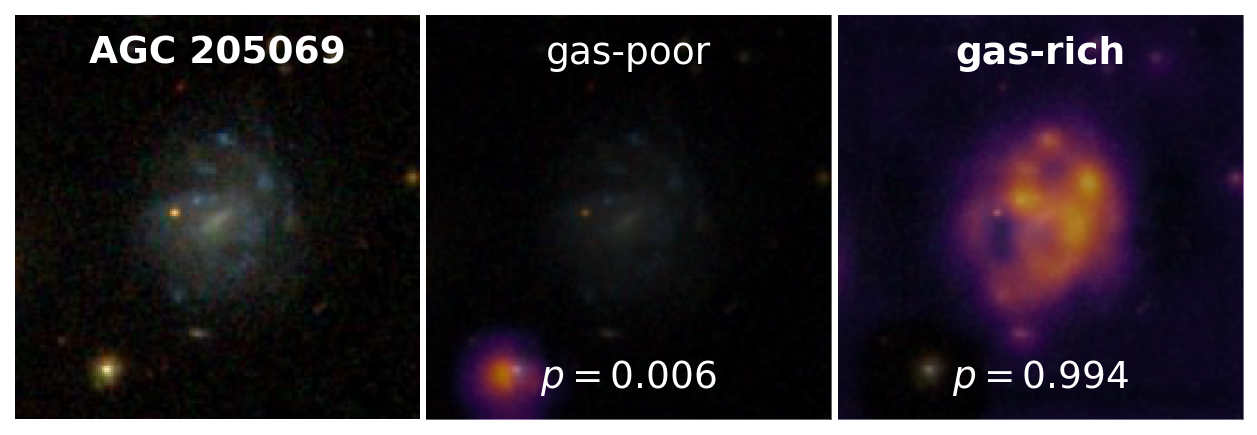

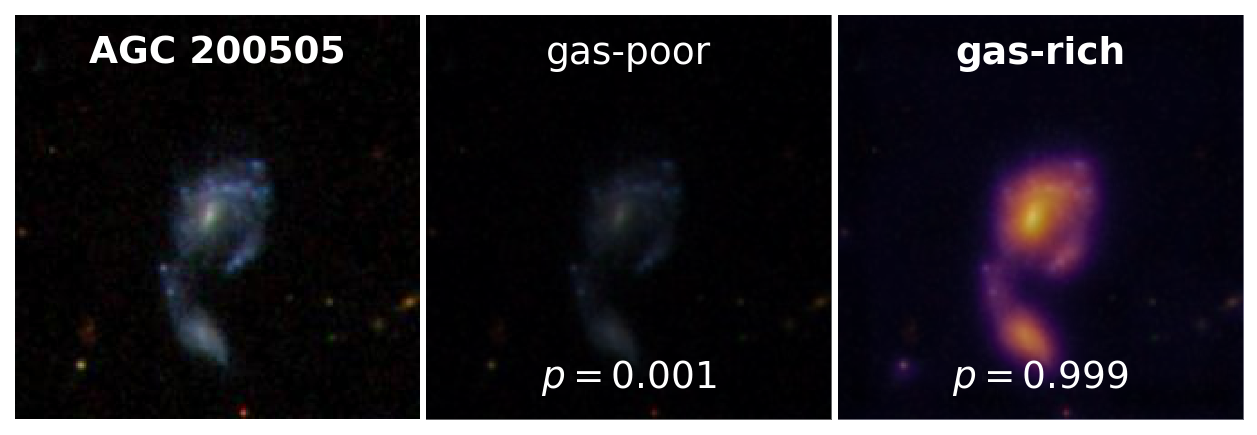

In [136]:
# gas rich examples
for name in np.array([4540, 8056, 243826, 212102, 248881, 723474, 205069, 200505,]).astype('str'):
    im = f'{PATH}/images-OC/{name}.jpg'
    x = norm(i2f(item_pipe(type_pipe(im)).cuda())).squeeze(0)
    fig, [ax0, ax1, ax2], p0, p1 = plot_gradcam(x, learn, hooked_layer=learn.model[5])
    
    is_gas_rich = a40.set_index('AGCNr').at[name, 'gas_rich']
    
    ax0.text(0.5, 0.88, f'AGC {name}', transform=ax0.transAxes, fontweight='bold', **text_dict)
    
    ax1.text(0.5, 0.88, 'gas-poor', transform=ax1.transAxes, fontweight='bold' if not is_gas_rich else None, **text_dict)
    ax1.text(0.5, 0.08, f'$p = {p0:.3f}$', transform=ax1.transAxes, **text_dict)
    
    ax2.text(0.5, 0.88, 'gas-rich', transform=ax2.transAxes, fontweight='bold' if is_gas_rich else None, **text_dict)
    ax2.text(0.5, 0.08, f'$p = {p1:.3f}$', transform=ax2.transAxes, **text_dict)
    
    fig.subplots_adjust()
    fig.show()


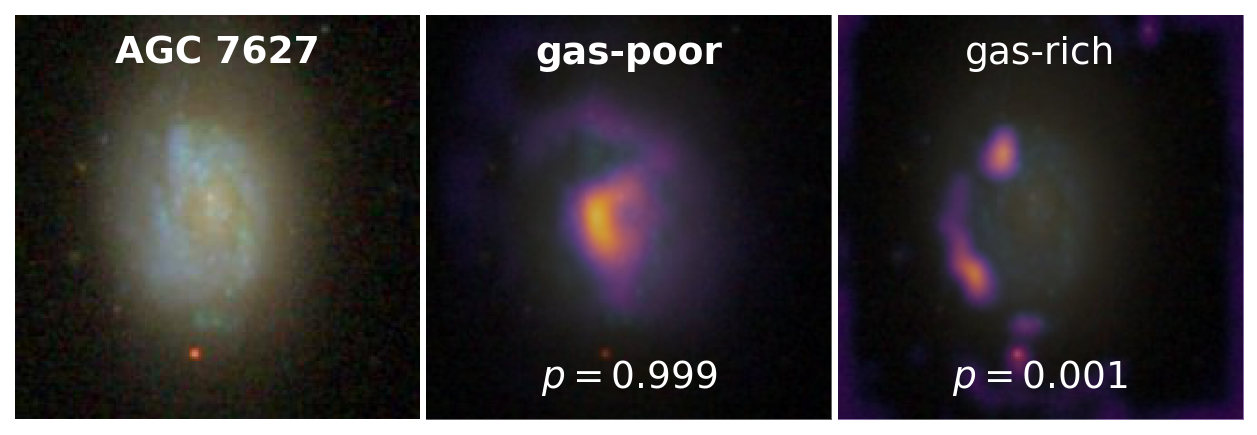

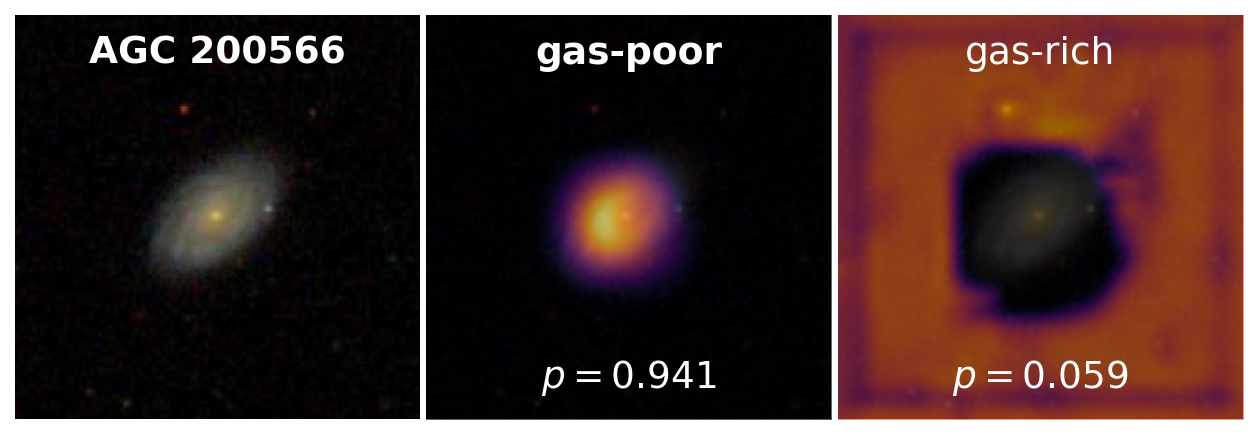

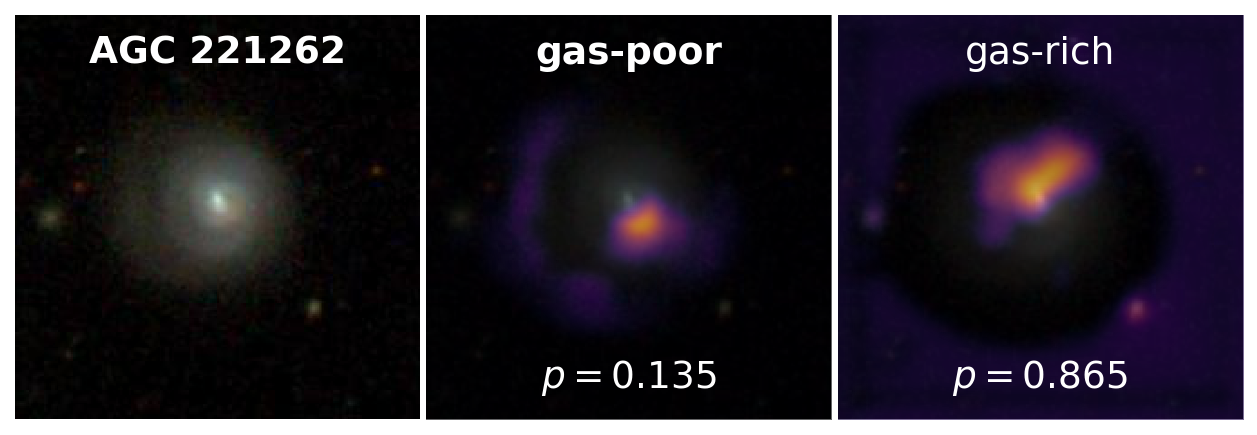

In [137]:
# gas poor examples
for name in np.array([7627, 200566, 221262, ]).astype('str'):
    im = f'{PATH}/images-OC/{name}.jpg'
    x = norm(i2f(item_pipe(type_pipe(im)).cuda())).squeeze(0)
    fig, [ax0, ax1, ax2], p0, p1 = plot_gradcam(x, learn, hooked_layer=learn.model[5])
    
    is_gas_rich = a40.set_index('AGCNr').at[name, 'gas_rich']
    
    ax0.text(0.5, 0.88, f'AGC {name}', transform=ax0.transAxes, fontweight='bold', **text_dict)
    
    ax1.text(0.5, 0.88, 'gas-poor', transform=ax1.transAxes, fontweight='bold' if not is_gas_rich else None, **text_dict)
    ax1.text(0.5, 0.08, f'$p = {p0:.3f}$', transform=ax1.transAxes, **text_dict)
    
    ax2.text(0.5, 0.88, 'gas-rich', transform=ax2.transAxes, fontweight='bold' if is_gas_rich else None, **text_dict)
    ax2.text(0.5, 0.08, f'$p = {p1:.3f}$', transform=ax2.transAxes, **text_dict)
    
    fig.subplots_adjust()
    fig.show()


## Get simple CNN model

In [115]:
class SimpleCNN(nn.Module):
    def __init__(self, pretrained=False):                 
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(64*28*28, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [138]:
model = SimpleCNN()

learn = Learner(
    dls, 
    model,
    metrics=accuracy,
    opt_func=ranger,
)

In [139]:
learn.fit_one_cycle(10, 1e-3)

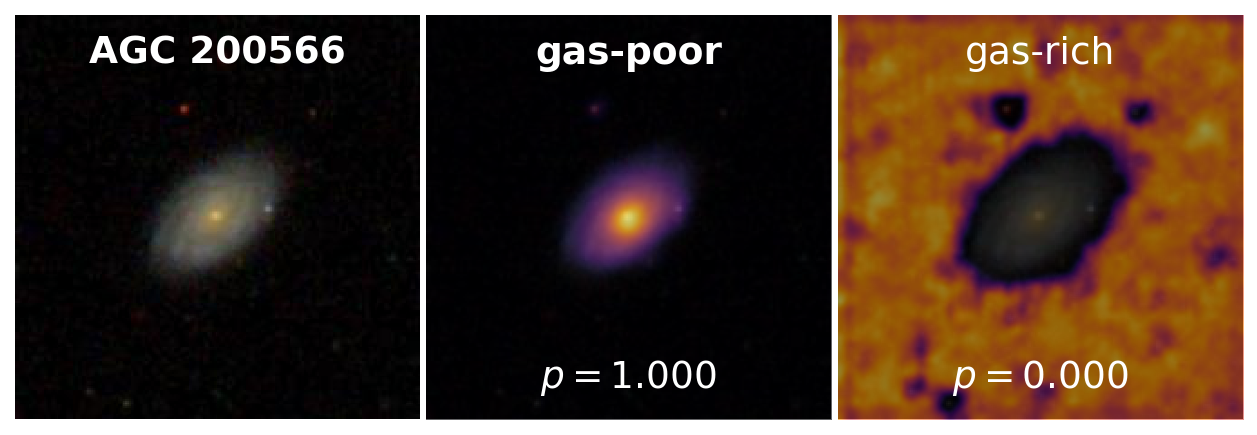

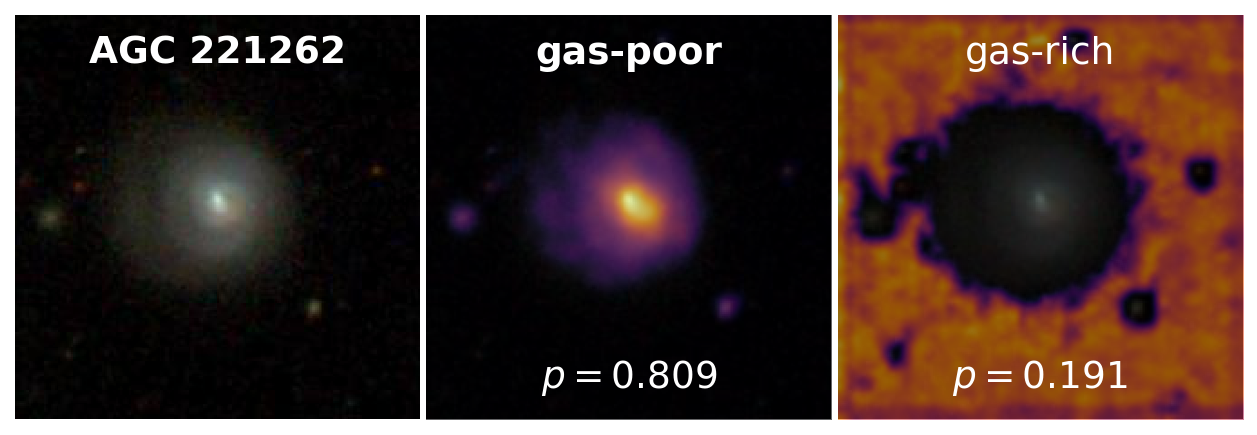

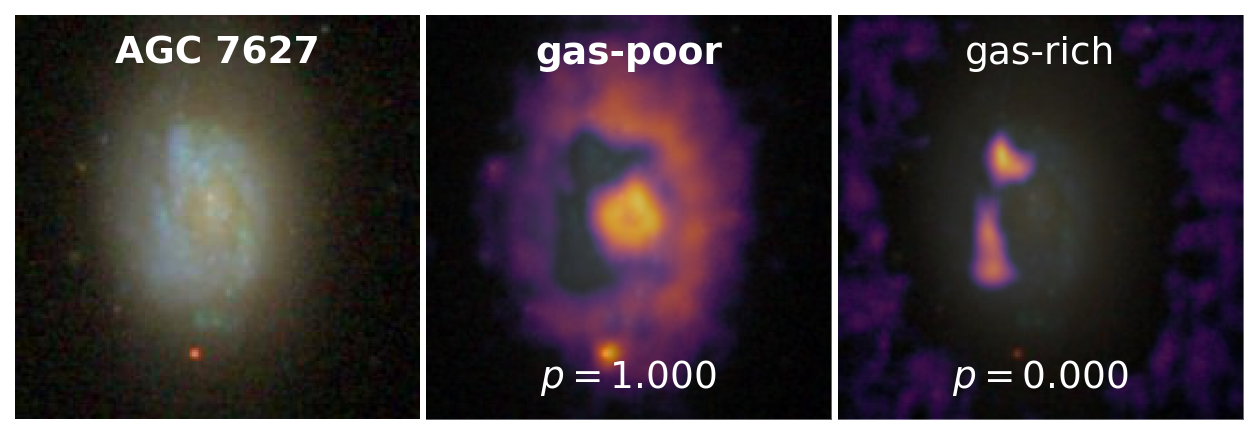

In [140]:
# gas poor examples
for name in np.array([200566, 221262, 7627]).astype('str'):
    im = f'{PATH}/images-OC/{name}.jpg'
    x = norm(i2f(item_pipe(type_pipe(im)).cuda())).squeeze(0)
    fig, [ax0, ax1, ax2], p0, p1 = plot_gradcam(x, learn, hooked_layer=learn.model.layer3[1])
    
    is_gas_rich = a40.set_index('AGCNr').at[name, 'gas_rich']
    
    ax0.text(0.5, 0.88, f'AGC {name}', transform=ax0.transAxes, fontweight='bold', **text_dict)
    
    ax1.text(0.5, 0.88, 'gas-poor', transform=ax1.transAxes, fontweight='bold' if not is_gas_rich else None, **text_dict)
    ax1.text(0.5, 0.08, f'$p = {p0:.3f}$', transform=ax1.transAxes, **text_dict)
    
    ax2.text(0.5, 0.88, 'gas-rich', transform=ax2.transAxes, fontweight='bold' if is_gas_rich else None, **text_dict)
    ax2.text(0.5, 0.08, f'$p = {p1:.3f}$', transform=ax2.transAxes, **text_dict)
    
    fig.subplots_adjust()
    fig.show()


# Test xGASS

In [141]:
xg = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")
xg = xg[(xg.lgGF > -0.5) | (xg.lgGF < -1.5)]
xg['gas_rich'] = np.where(xg.lgGF > -1, True, False)

In [142]:
xg_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['GASS'], pref=f'{PATH}/images-xGASS/', suff='.jpg'),
    get_y=Pipeline([ColReader(['gas_rich'])]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

xg_dls = ImageDataLoaders.from_dblock(xg_dblock, xg, path=PATH, bs=64)

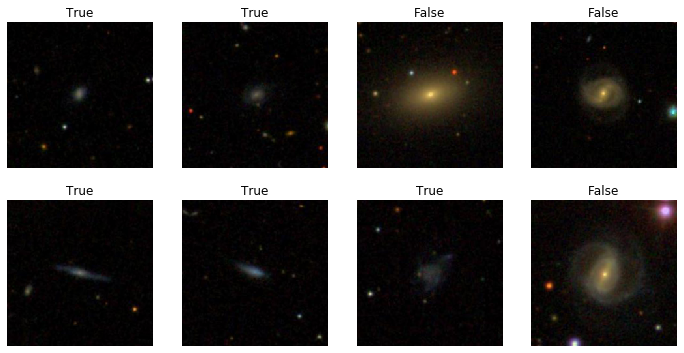

In [143]:
dls.show_batch(nrows=2, ncols=4)

## Train model and check

In [144]:
model = XResNet(ResBlock, 1, [2, 2], stem_szs=[16, 32, 64])
model[-1] = nn.Linear(in_features=128, out_features=2)

learn = Learner(
    xg_dls, 
    model,
    metrics=accuracy,
    opt_func=ranger,
)

In [145]:
learn.fit_one_cycle(10, 1e-2)

## Grad-CAM

In [146]:
type_tfms = [PILImage.create]
item_tfms = [Resize(224), ToTensor()]
type_pipe = Pipeline(type_tfms)
item_pipe = Pipeline(item_tfms)
norm = Normalize.from_stats(*image_stats)
i2f = IntToFloatTensor()

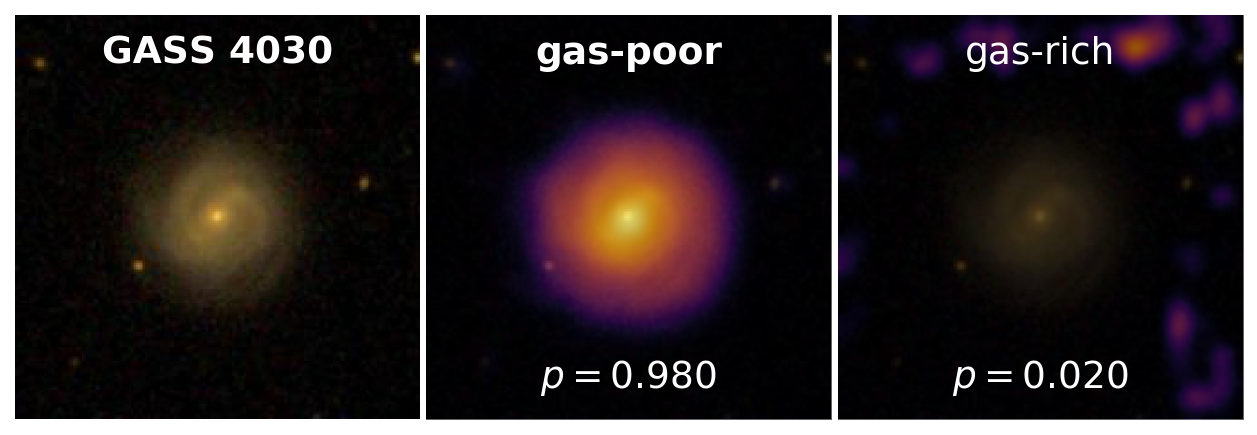

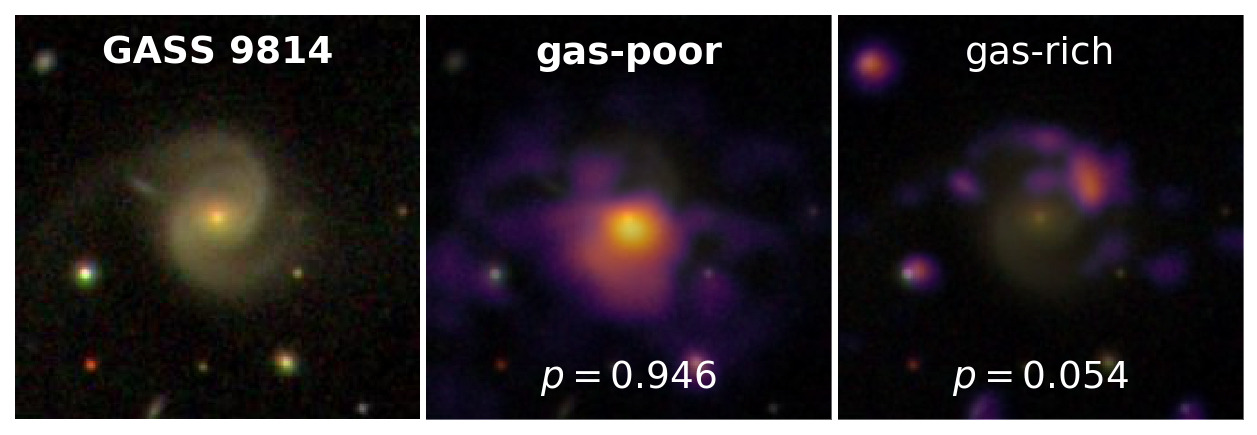

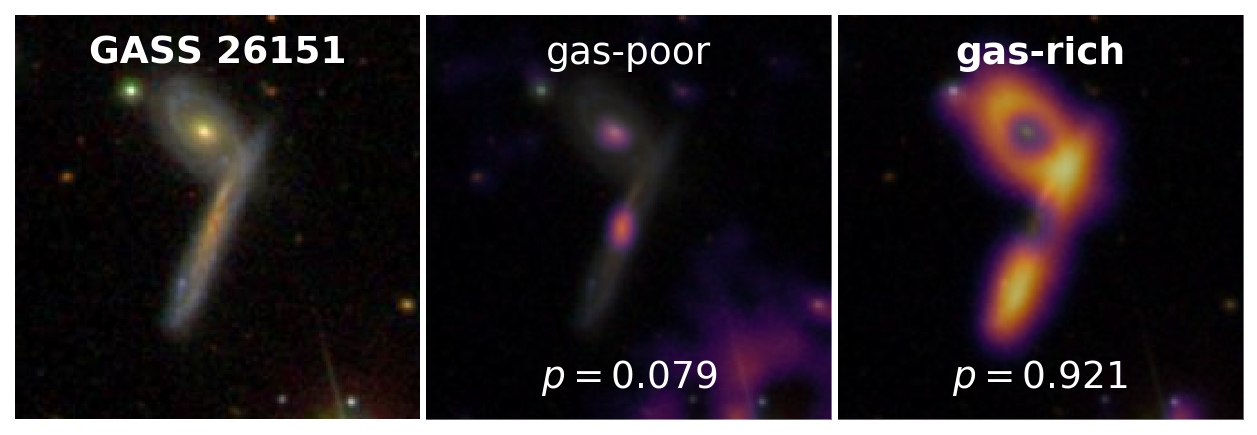

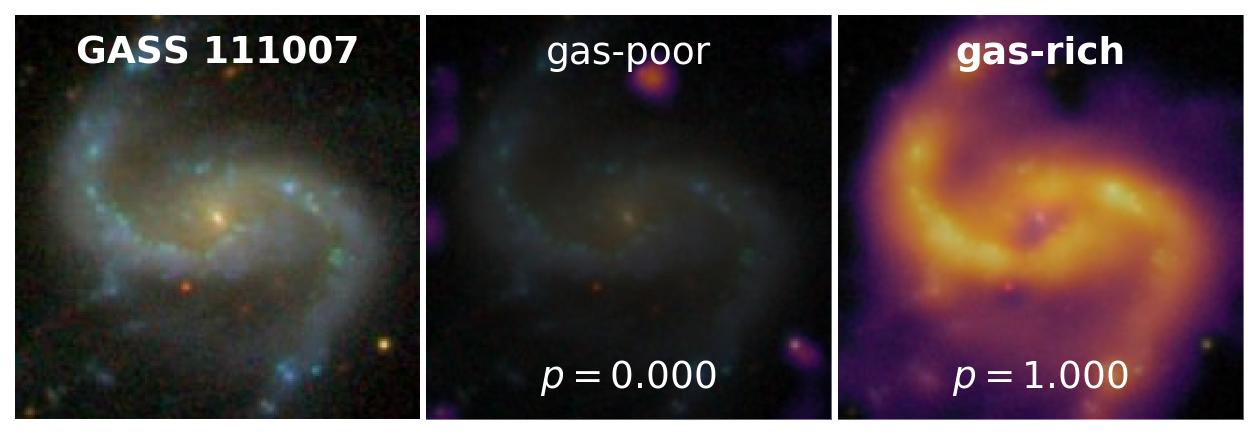

In [153]:
for name in np.array([4030, 9814, 26151, 111007]).astype(int):
    im = f'{PATH}/images-xGASS/{name}.jpg'
    x = norm(i2f(item_pipe(type_pipe(im)).cuda())).squeeze(0)
    fig, [ax0, ax1, ax2], p0, p1 = plot_gradcam(x, learn, hooked_layer=learn.model[5])
    
    is_gas_rich = xg.set_index('GASS').at[name, 'gas_rich']
    
    ax0.text(0.5, 0.88, f'GASS {name}', transform=ax0.transAxes, fontweight='bold', **text_dict)
    
    ax1.text(0.5, 0.88, 'gas-poor', transform=ax1.transAxes, fontweight='bold' if not is_gas_rich else None, **text_dict)
    ax1.text(0.5, 0.08, f'$p = {p0:.3f}$', transform=ax1.transAxes, **text_dict)
    
    ax2.text(0.5, 0.88, 'gas-rich', transform=ax2.transAxes, fontweight='bold' if is_gas_rich else None, **text_dict)
    ax2.text(0.5, 0.08, f'$p = {p1:.3f}$', transform=ax2.transAxes, **text_dict)
    
    fig.subplots_adjust()
    fig.show()

